In [216]:
import cv2
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

In [217]:
img_file = '../資料擴增/composition/65715903.jpg'
img = cv2.imread(img_file)

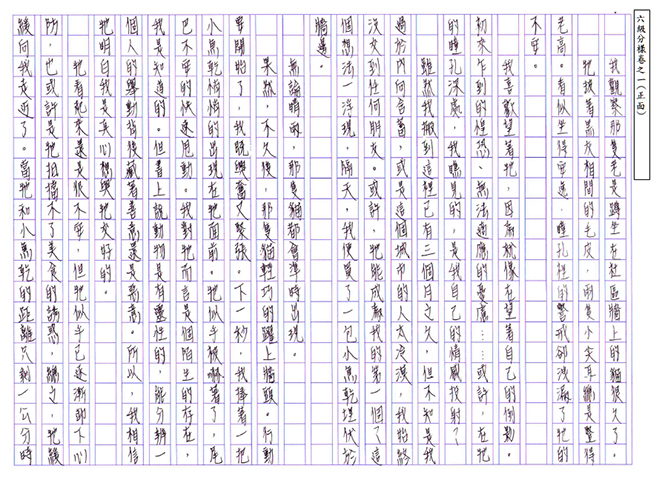

In [218]:
Image.fromarray(img)

In [219]:
# (h, w) = img.shape[:2]
# center = (w/2, h/2)

# M = cv2.getRotationMatrix2D(center, 15, 1.0)
# img = cv2.warpAffine(img, M, (w, h))

# Image.fromarray(img)

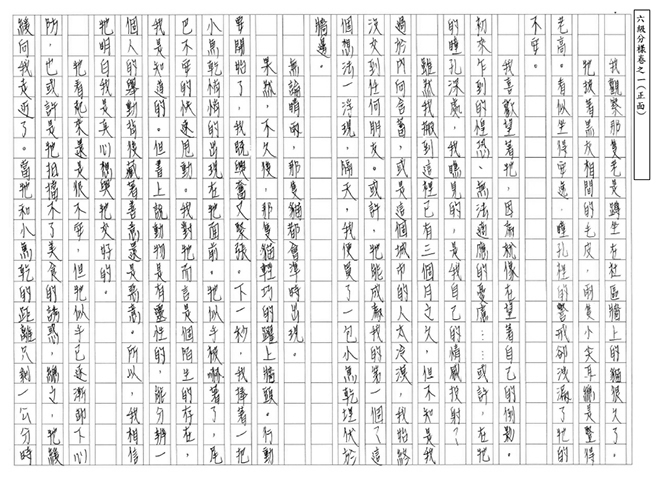

In [220]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
Image.fromarray(gray)

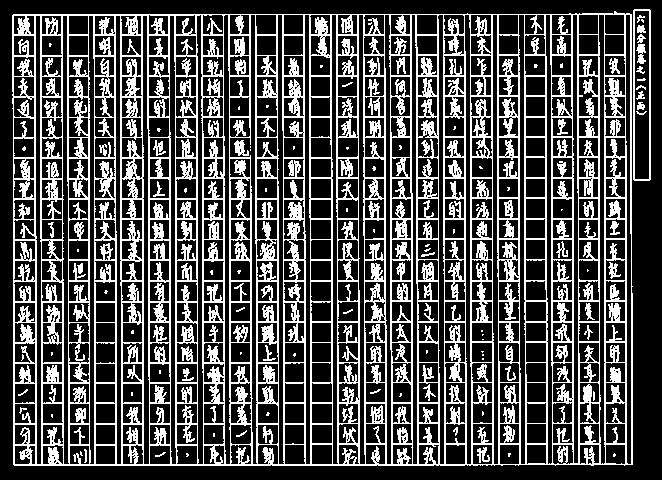

In [221]:
ret, img_bin = cv2.threshold(gray, 235, 255, cv2.THRESH_BINARY)
img_bin=~img_bin
Image.fromarray(img_bin)

In [222]:
line_min_width = 15
kernal_h = np.ones((1, line_min_width), np.uint8)
kernal_v = np.ones((line_min_width, 1), np.uint8)

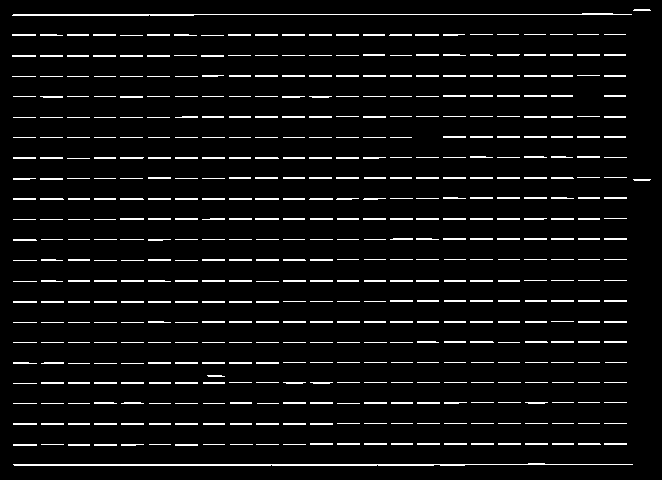

In [223]:
img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)
Image.fromarray(img_bin_h)

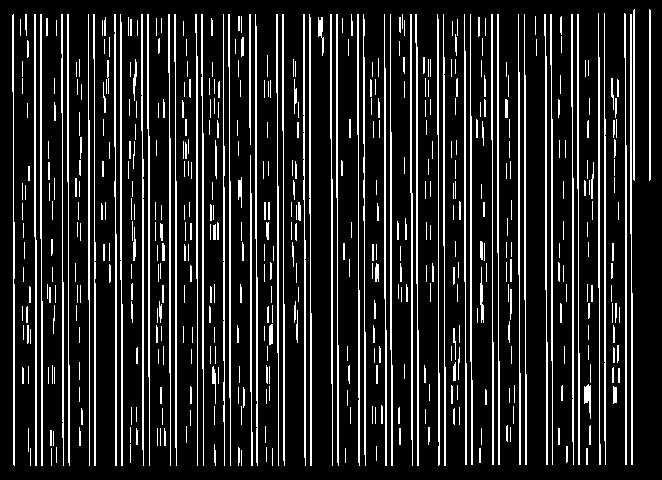

In [224]:
img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)
Image.fromarray(img_bin_v)

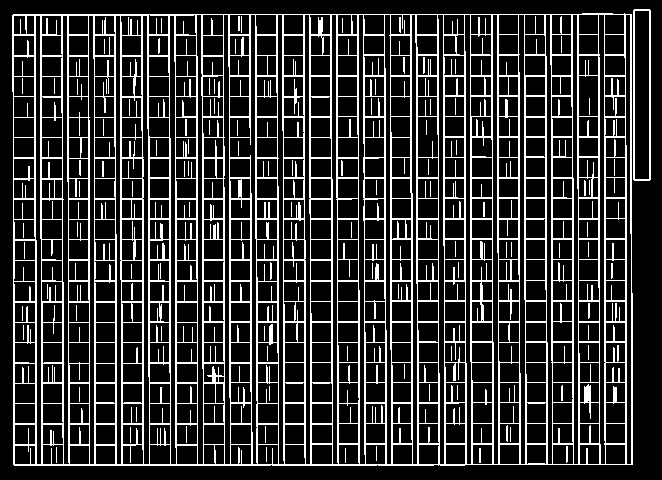

In [225]:
img_bin_final = img_bin_h | img_bin_v
Image.fromarray(img_bin_final)

In [226]:
_, labels, stats,_ = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)

In [227]:
# for x,y,w,h,area in stats[2:]:
#     cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    
# Image.fromarray(img)

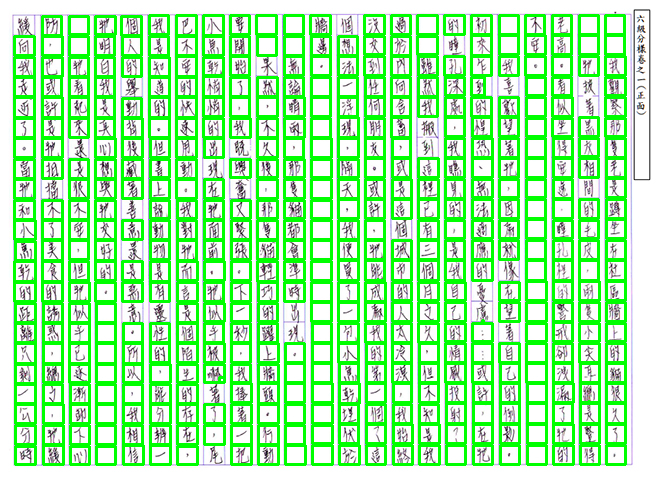

In [228]:
img_ = img.copy()
for x,y,w,h,area in stats[2:]:
    if abs(w-h) / max(w,h) < 0.3:
        cv2.rectangle(img_,(x,y),(x+w,y+h),(0,255,0),2)

Image.fromarray(img_)

In [229]:
for x,y,w,h,area in stats[2:]:
    if abs(w-h) / max(w,h) < 0.3:
        cropped_img = gray[y:y+h, x:x+w]
        resized_img = cv2.resize(cropped_img, (50, 50), interpolation=cv2.INTER_CUBIC)
        
        cv2.imwrite('test.jpg', resized_img)
        
        sigma = 100
        blur_img = cv2.GaussianBlur(resized_img, (0, 0), sigma)
        usm = cv2.addWeighted(resized_img, 1.5, blur_img, -0.5, 0)
        cv2.imwrite('test_1.jpg', usm)
        
        break

In [230]:
# binarize the image
ret, bw = cv2.threshold(resized_img, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) 

# find connected components
connectivity = 8
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(bw, connectivity, cv2.CV_32S)
sizes = stats[1:, -1]
nb_components = nb_components - 1

# 白底黑字 image
new_img = np.full((resized_img.shape), 255, np.uint8)
img_area = new_img.shape[0] * new_img.shape[1]

for i in range(0, nb_components):
    new_img[output == i + 1] = 0

# side_length = max(img.shape[:-1])
# padded_img = np.full((side_length, side_length, 3), 255, np.uint8)

image = Image.fromarray(new_img).resize((50,50))
# display(image)
image.save('test_2.jpg')

# 整理

In [247]:
def sharpen_img(img):
    # binarize the image
    ret, bw = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) 

    # find connected components
    connectivity = 8
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(bw, connectivity, cv2.CV_32S)
    sizes = stats[1:, -1]
    nb_components = nb_components - 1

    # 白底黑字 image
    new_img = np.full((img.shape), 255, np.uint8)
    img_area = new_img.shape[0] * new_img.shape[1]

    for i in range(0, nb_components):
        new_img[output == i + 1] = 0
        
    return img

In [302]:
def crop_cell_from_img(file):
    basename = os.path.basename(file)
    basename = basename.split('.')[0]
    
    basepath = os.path.join('dataset/composition', basename)

    if os.path.exists(basepath) == False:
        os.mkdir(basepath)
    
    img = cv2.imread(file)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    ret, img_bin = cv2.threshold(gray, 235, 255, cv2.THRESH_BINARY)
    img_bin=~img_bin

    line_min_width = 15
    kernal_h = np.ones((1, line_min_width), np.uint8)
    kernal_v = np.ones((line_min_width, 1), np.uint8)

    img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)
    Image.fromarray(img_bin_h)

    img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)
    Image.fromarray(img_bin_v)

    img_bin_final = img_bin_h | img_bin_v
    Image.fromarray(img_bin_final)

    _, labels, stats,_ = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)
    
    i = 0
    for x,y,w,h,area in stats[2:]:
        if abs(w-h) / max(w,h) < 0.3:
            cropped_img = gray[y:y+h, x:x+w]
            resized_img = cv2.resize(cropped_img, (50, 50), interpolation=cv2.INTER_CUBIC)
            
            sharpped_img = sharpen_img(resized_img)
            
            cv2.imwrite(os.path.join(basepath, '%d.jpg'%i), sharpped_img)
            i+=1

In [304]:
files = glob.glob('../資料擴增/composition/*')

for file in tqdm(files):
    crop_cell_from_img(file)

100%|██████████| 7/7 [00:00<00:00, 10.22it/s]
